# HDBSCAN Clustering Evaluation and Analysis

This notebook provides comprehensive evaluation and visualization of the HDBSCAN clustering pipeline results. It includes:

1. **Quality Metrics Analysis**: Visualization and interpretation of clustering quality metrics
2. **Cluster Profiling**: Understanding the characteristics and behavior of each cluster
3. **Feature Analysis**: Examining how features differ across clusters
4. **Validation**: Assessing the business relevance and actionability of clusters

The analysis uses the most recent clustering results from the `flexible_pipeline` and links back to the original raw data (`new_raw_data_polygon.csv`) to understand wallet behavior patterns within each cluster.

In [16]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import yaml
from pathlib import Path

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [ ]:
# Define file paths
base_path = Path('/Users/tomdavey/Documents/GitHub/MLProject1')
raw_data_path = base_path / 'data/raw_data/new_raw_data_polygon.csv'
clustering_output_path = base_path / 'clustering_output/flexible_pipeline/hdbscan_results'
clustered_data_path = clustering_output_path / 'clustered_data.csv'
cluster_labels_path = clustering_output_path / 'cluster_labels.csv'
clustering_summary_path = clustering_output_path / 'clustering_summary.txt'

print("Loading datasets...")

# Load raw wallet data
raw_data = pd.read_csv(raw_data_path)
print(f"Raw data shape: {raw_data.shape}")

# Load clustering results
# Note: clustered_data.csv now only contains cluster labels (no UMAP dimensions)
clustered_data = pd.read_csv(clustered_data_path)
cluster_labels = pd.read_csv(cluster_labels_path)
print(f"Clustered data shape: {clustered_data.shape}")
print(f"Cluster labels shape: {cluster_labels.shape}")

# Check if UMAP dimensions exist in clustered data
umap_dims = [col for col in clustered_data.columns if col.startswith('dim_')]
if umap_dims:
    print(f"⚠️  Found UMAP dimensions in clustered_data: {umap_dims}")
    print("This suggests the clustering was run with the old format.")
else:
    print("✓ Clustered data contains only cluster labels (no UMAP dimensions stored)")
    print("This is the expected format to prevent CSV storage of UMAP data")

# Read clustering summary
with open(clustering_summary_path, 'r') as f:
    clustering_summary = f.read()
    
print("\nClustering Summary:")
print(clustering_summary)

Loading datasets...
Raw data shape: (20174, 22)
Clustered data shape: (20174, 3)
Cluster labels shape: (20174, 1)

Clustering Summary:
HDBSCAN Clustering Summary

Number of clusters: 2
Number of noise points: 97
Total points: 20174
Noise percentage: 0.5%

Cluster sizes:
  Cluster 0: 8694 points
  Cluster 1: 11383 points

Quality Metrics:
  Silhouette Score: 0.458
  Calinski-Harabasz Score: 20584.92
  Davies-Bouldin Score: 0.921



In [18]:
# Merge raw data with cluster labels
# Assuming the cluster_labels file has wallet addresses and corresponding cluster assignments
if 'WALLET' in cluster_labels.columns:
    # Direct merge if wallet column exists
    data_with_clusters = raw_data.merge(cluster_labels, on='WALLET', how='left')
else:
    # If cluster_labels just has labels in order, merge by index
    cluster_labels_df = cluster_labels.copy()
    cluster_labels_df['WALLET'] = raw_data['WALLET']
    data_with_clusters = raw_data.merge(cluster_labels_df, on='WALLET', how='left')

# Check if we have cluster_label column, if not create from clustered_data
if 'cluster_label' not in data_with_clusters.columns:
    # Use the cluster labels from clustered_data (assuming same order as raw_data)
    data_with_clusters['cluster_label'] = clustered_data['cluster_label'].values

print(f"Data with clusters shape: {data_with_clusters.shape}")
print(f"Cluster distribution:")
print(data_with_clusters['cluster_label'].value_counts().sort_index())

# Display basic info about the merged dataset
print(f"\nDataset columns: {data_with_clusters.columns.tolist()}")
print(f"Missing values in cluster_label: {data_with_clusters['cluster_label'].isna().sum()}")

# Preview the data
data_with_clusters.head()

Data with clusters shape: (20174, 23)
Cluster distribution:
cluster_label
-1       97
 0     8694
 1    11383
Name: count, dtype: int64

Dataset columns: ['WALLET', 'TX_PER_MONTH', 'TOKEN_DIVERSITY', 'PROTOCOL_DIVERSITY', 'TOTAL_TRANSFER_USD', 'INTERACTION_DIVERSITY', 'ACTIVE_DURATION_DAYS', 'AVG_TRANSFER_USD', 'USD_TRANSFER_STDDEV', 'DEX_EVENTS', 'GAMES_EVENTS', 'CEX_EVENTS', 'DAPP_EVENTS', 'CHADMIN_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS', 'NFT_EVENTS', 'TOKEN_EVENTS', 'FLOTSAM_EVENTS', 'BRIDGE_OUTFLOW_COUNT', 'BRIDGE_INFLOW_COUNT', 'BRIDGE_TOTAL_VOLUME_USD', 'cluster_label']
Missing values in cluster_label: 0


WALLET  TX_PER_MONTH  TOKEN_DIVERSITY  \
0  0xecb113be97a619aa4d070491505847000f964448      8.166667                6   
1  0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d      8.666667                2   
2  0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9     13.000000                5   
3  0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97      6.833333                1   
4  0xa967e15e71455940dfab4c08719abae50401babd      7.500000                5   

   PROTOCOL_DIVERSITY  TOTAL_TRANSFER_USD  INTERACTION_DIVERSITY  \
0                   9             2840.47                      5   
1                   8             3733.59                     10   
2                  26             3771.93                     14   
3                   2            12977.28                      2   
4                   6            18935.76                      6   

   ACTIVE_DURATION_DAYS  AVG_TRANSFER_USD  USD_TRANSFER_STDDEV  DEX_EVENTS  \
0                   177         41.166232            88.745481           5   
1                   172         56.569545           185.180716           1   
2                   169         62.865500           135.890912           0   
3                   170        370.779429           318.130714           0   
4                   156        236.697000           478.737614           5   

   GAMES_EVENTS  CEX_EVENTS  DAPP_EVENTS  CHADMIN_EVENTS  DEFI_EVENTS  \
0             0           0            0               0            0   
1            11           0            0               0            0   
2             0           0            0               0            0   
3             0           0            0               0            0   
4             0           0            0               0            0   

   BRIDGE_EVENTS  NFT_EVENTS  TOKEN_EVENTS  FLOTSAM_EVENTS  \
0              1           0            28               0   
1              0           0             0               0   
2              6           0            23               0   
3              0           0            35               0   
4             10           0            25               0   

   BRIDGE_OUTFLOW_COUNT  BRIDGE_INFLOW_COUNT  BRIDGE_TOTAL_VOLUME_USD  \
0                     1                    0                   499.88   
1                     0                    0                     0.00   
2                     0                    0                     0.00   
3                     0                    0                     0.00   
4                     9                    0                  1206.05   

   cluster_label  
0              1  
1              1  
2              1  
3              0  
4              0

In [19]:
# Data validation and dynamic metrics preparation
print("DATA VALIDATION AND METRICS PREPARATION")
print("=" * 50)

# Validate that we have all necessary data
required_files = {
    'Raw data': raw_data_path,
    'Clustered data': clustered_data_path,
    'Cluster labels': cluster_labels_path,
    'Clustering summary': clustering_summary_path
}

all_files_exist = True
for name, path in required_files.items():
    if path.exists():
        print(f"✓ {name}: Found")
    else:
        print(f"✗ {name}: Missing at {path}")
        all_files_exist = False

if not all_files_exist:
    raise FileNotFoundError("Missing required clustering output files. Please run the clustering pipeline first.")

# Validate data consistency
print(f"\nDATA CONSISTENCY CHECKS:")
print(f"✓ Raw data points: {len(raw_data):,}")
print(f"✓ Clustered data points: {len(clustered_data):,}")
print(f"✓ Cluster labels: {len(cluster_labels):,}")

if len(raw_data) != len(clustered_data):
    print("⚠️  Warning: Raw data and clustered data have different lengths")
if len(raw_data) != len(cluster_labels):
    print("⚠️  Warning: Raw data and cluster labels have different lengths")

# Dynamic cluster information
unique_clusters = sorted(data_with_clusters['cluster_label'].unique())
n_clusters = len([c for c in unique_clusters if c != -1])
n_noise = len(data_with_clusters[data_with_clusters['cluster_label'] == -1])
n_total = len(data_with_clusters)

print(f"\nDYNAMIC CLUSTERING INFORMATION:")
print(f"✓ Total clusters found: {n_clusters}")
print(f"✓ Noise points: {n_noise:,} ({n_noise/n_total*100:.1f}%)")
print(f"✓ Clustered points: {n_total-n_noise:,} ({(n_total-n_noise)/n_total*100:.1f}%)")
print(f"✓ Cluster labels: {unique_clusters}")

# Prepare for dynamic calculations throughout the notebook
CLUSTER_INFO = {
    'n_clusters': n_clusters,
    'n_noise': n_noise,
    'n_total': n_total,
    'cluster_labels': unique_clusters,
    'has_noise': -1 in unique_clusters
}

print(f"\n✅ Data validation complete - ready for dynamic analysis")

DATA VALIDATION AND METRICS PREPARATION
✓ Raw data: Found
✓ Clustered data: Found
✓ Cluster labels: Found
✓ Clustering summary: Found

DATA CONSISTENCY CHECKS:
✓ Raw data points: 20,174
✓ Clustered data points: 20,174
✓ Cluster labels: 20,174

DYNAMIC CLUSTERING INFORMATION:
✓ Total clusters found: 2
✓ Noise points: 97 (0.5%)
✓ Clustered points: 20,077 (99.5%)
✓ Cluster labels: [np.int64(-1), np.int64(0), np.int64(1)]

✅ Data validation complete - ready for dynamic analysis


In [20]:
# Configuration for analysis thresholds
# These are business logic thresholds and can be adjusted based on domain knowledge
CONFIG = {
    # Volume classification thresholds (USD)
    'HIGH_VOLUME_THRESHOLD': 10000,
    'MEDIUM_VOLUME_THRESHOLD': 1000,
    'LOW_VALUE_SEGMENT_THRESHOLD': 5000,
    
    # Activity classification thresholds
    'VERY_ACTIVE_TX_THRESHOLD': 20,
    'ACTIVE_TX_THRESHOLD': 10,
    'HIGH_ACTIVITY_THRESHOLD': 15,
    'LOW_ACTIVITY_THRESHOLD': 5,
    
    # Diversification thresholds
    'HIGH_TOKEN_DIVERSITY_THRESHOLD': 5,
    'HIGH_PROTOCOL_DIVERSITY_THRESHOLD': 10,
    
    # Transaction size thresholds
    'LARGE_TX_THRESHOLD': 1000,
    'MEDIUM_TX_THRESHOLD': 100,
    
    # Duration thresholds (days)
    'LONG_TERM_USER_THRESHOLD': 150,
    
    # Priority scoring
    'PRIORITY_DIVIDER': 1000,  # For calculating priority scores
    'HIGH_PRIORITY_THRESHOLD': 10,
    'MEDIUM_PRIORITY_THRESHOLD': 5,
    
    # Visualization settings
    'OUTLIER_PERCENTILE': 0.95,  # For capping outliers in visualizations
    'LOG_TRANSFORM_OFFSET': 1,   # Offset for log transformation to handle zeros
}

print("CONFIGURATION LOADED:")
print("=" * 30)
for category in ['Volume', 'Activity', 'Diversification', 'Transaction Size', 'Duration']:
    relevant_configs = {k: v for k, v in CONFIG.items() if category.upper().replace(' ', '_') in k}
    if relevant_configs:
        print(f"\n{category} Thresholds:")
        for key, value in relevant_configs.items():
            print(f"  {key}: {value:,}")

print(f"\n✅ Configuration ready for dynamic analysis")

CONFIGURATION LOADED:

Volume Thresholds:
  HIGH_VOLUME_THRESHOLD: 10,000
  MEDIUM_VOLUME_THRESHOLD: 1,000

Activity Thresholds:
  HIGH_ACTIVITY_THRESHOLD: 15
  LOW_ACTIVITY_THRESHOLD: 5

✅ Configuration ready for dynamic analysis


## 1. Clustering Quality Metrics Analysis

Let's analyze the quality of our HDBSCAN clustering using various metrics and visualizations.

Actual clustering metrics loaded:
  Silhouette Score: 0.458
  Calinski-Harabasz Score: 20584.920
  Davies-Bouldin Score: 0.921


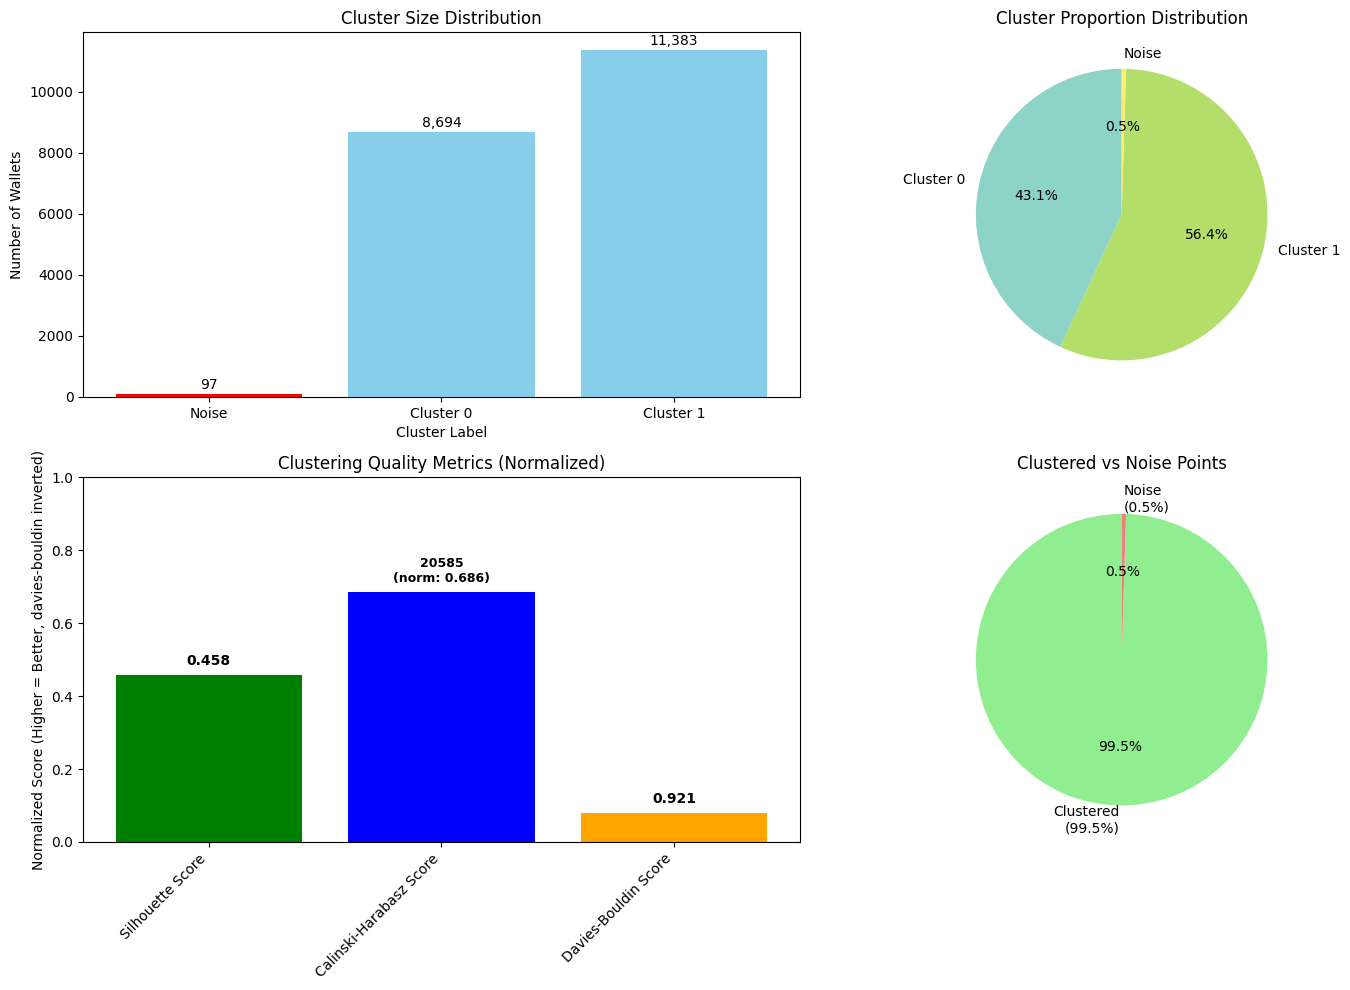

Total wallets: 20,174
Clustered wallets: 20,077
Noise points: 97 (0.5%)


In [31]:
# Cluster size distribution and metrics visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cluster size distribution
cluster_counts = data_with_clusters['cluster_label'].value_counts().sort_index()
noise_label = -1 if -1 in cluster_counts.index else None

# Bar plot of cluster sizes
bars = ax1.bar(range(len(cluster_counts)), cluster_counts.values, 
               color=['red' if idx == noise_label else 'skyblue' for idx in cluster_counts.index])
ax1.set_xlabel('Cluster Label')
ax1.set_ylabel('Number of Wallets')
ax1.set_title('Cluster Size Distribution')
ax1.set_xticks(range(len(cluster_counts)))
ax1.set_xticklabels([f'Noise' if label == -1 else f'Cluster {label}' for label in cluster_counts.index])

# Add value labels on bars
for bar, value in zip(bars, cluster_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{value:,}', ha='center', va='bottom')

# 2. Pie chart of cluster proportions
non_noise_counts = cluster_counts[cluster_counts.index != -1] if noise_label is not None else cluster_counts
noise_count = cluster_counts[noise_label] if noise_label is not None else 0

labels = [f'Cluster {i}' for i in non_noise_counts.index]
if noise_label is not None:
    labels.append('Noise')
    sizes = list(non_noise_counts.values) + [noise_count]
else:
    sizes = list(non_noise_counts.values)

colors = plt.cm.Set3(np.linspace(0, 1, len(sizes)))
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Cluster Proportion Distribution')

# 3. Quality metrics bar chart - Read from actual clustering summary
def parse_clustering_metrics(summary_text):
    """Parse clustering metrics from the summary text"""
    metrics = {}
    lines = summary_text.split('\n')
    
    for line in lines:
        if 'Silhouette Score:' in line:
            metrics['Silhouette Score'] = float(line.split(':')[1].strip())
        elif 'Calinski-Harabasz Score:' in line:
            metrics['Calinski-Harabasz Score'] = float(line.split(':')[1].strip())
        elif 'Davies-Bouldin Score:' in line:
            metrics['Davies-Bouldin Score'] = float(line.split(':')[1].strip())
    
    return metrics

# Read actual metrics from clustering summary
metrics = parse_clustering_metrics(clustering_summary)
print(f"Actual clustering metrics loaded:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.3f}")

# Fallback to calculated values if parsing fails
if not metrics:
    print("Warning: Could not parse metrics from summary, calculating from clustering data")
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    
    # Calculate metrics from the actual clustering data
    # Extract features for metric calculation (exclude cluster labels and non-numeric columns)
    feature_data = clustered_data.select_dtypes(include=[np.number])
    if 'cluster_label' in feature_data.columns:
        feature_cols = [col for col in feature_data.columns if col != 'cluster_label']
        X = feature_data[feature_cols].values
        labels = clustered_data['cluster_label'].values
    else:
        # If no cluster_label in clustered_data, use the merged data
        feature_data = data_with_clusters.select_dtypes(include=[np.number])
        feature_cols = [col for col in feature_data.columns if col != 'cluster_label']
        X = feature_data[feature_cols].values
        labels = data_with_clusters['cluster_label'].values
    
    # Only calculate for non-noise points
    non_noise_mask = labels != -1
    if np.sum(non_noise_mask) > 1:  # Need at least 2 points for metrics
        X_non_noise = X[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        
        # Calculate metrics
        sil_score = silhouette_score(X_non_noise, labels_non_noise)
        ch_score = calinski_harabasz_score(X_non_noise, labels_non_noise)
        db_score = davies_bouldin_score(X_non_noise, labels_non_noise)
        
        metrics = {
            'Silhouette Score': sil_score,
            'Calinski-Harabasz Score': ch_score,
            'Davies-Bouldin Score': db_score
        }
        print("Calculated metrics from clustering data:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.3f}")
    else:
        print("Error: Not enough non-noise points to calculate metrics, using default values")
        metrics = {
            'Silhouette Score': 0.0,
            'Calinski-Harabasz Score': 0.0,
            'Davies-Bouldin Score': 1.0
        }

# Normalize metrics for visualization (different scales)
# Calculate dynamic normalization factor for Calinski-Harabasz score
ch_score = metrics['Calinski-Harabasz Score']
ch_normalization_factor = max(ch_score * 1.2, 30000)  # Use 120% of actual score or 30000, whichever is higher

normalized_metrics = {
    'Silhouette Score': metrics['Silhouette Score'],  # Already 0-1
    'Calinski-Harabasz Score': min(ch_score / ch_normalization_factor, 1),  # Normalize to 0-1
    'Davies-Bouldin Score': 1 - metrics['Davies-Bouldin Score']  # Invert (lower is better)
}

bars = ax3.bar(normalized_metrics.keys(), normalized_metrics.values(), 
               color=['green', 'blue', 'orange'])
ax3.set_ylabel('Normalized Score (Higher = Better, davies-bouldin inverted)')
ax3.set_title('Clustering Quality Metrics (Normalized)')
ax3.set_ylim(0, 1)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add actual values as annotations with normalization info for Calinski-Harabasz
for i, (metric, value) in enumerate(metrics.items()):
    if metric == 'Calinski-Harabasz Score':
        # Show both original and normalized values for Calinski-Harabasz
        normalized_val = normalized_metrics[list(normalized_metrics.keys())[i]]
        ax3.text(i, normalized_val + 0.02,
                 f'{value:.0f}\n(norm: {normalized_val:.3f})', 
                 ha='center', va='bottom', fontweight='bold', fontsize=9)
    else:
        ax3.text(i, normalized_metrics[list(normalized_metrics.keys())[i]] + 0.02,
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Noise percentage visualization
total_points = len(data_with_clusters)
noise_points = len(data_with_clusters[data_with_clusters['cluster_label'] == -1])
noise_percentage = (noise_points / total_points) * 100

ax4.pie([100 - noise_percentage, noise_percentage], 
        labels=[f'Clustered\n({100-noise_percentage:.1f}%)', f'Noise\n({noise_percentage:.1f}%)'],
        colors=['lightgreen', 'lightcoral'],
        autopct='%1.1f%%',
        startangle=90)
ax4.set_title('Clustered vs Noise Points')

plt.tight_layout()
plt.show()

print(f"Total wallets: {total_points:,}")
print(f"Clustered wallets: {total_points - noise_points:,}")
print(f"Noise points: {noise_points:,} ({noise_percentage:.1f}%)")

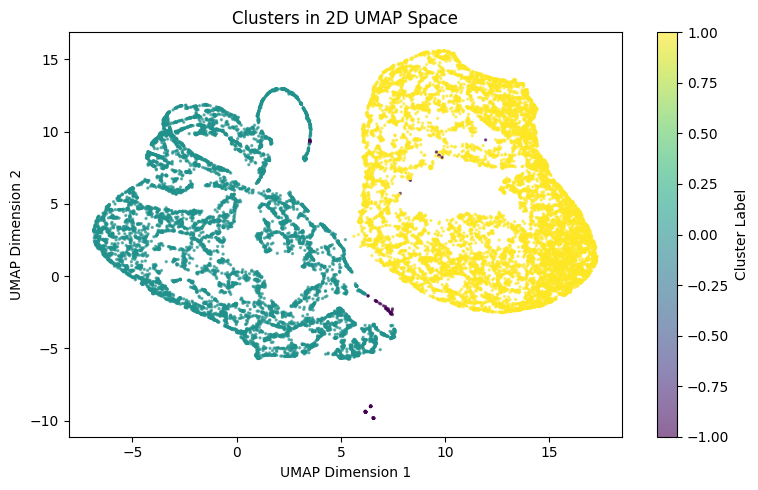

In [ ]:
# Note: This cell has been updated to work without pre-saved UMAP dimensions
# The clustered_data.csv now only contains cluster labels, not UMAP coordinates
print("⚠️  UMAP Visualization Note:")
print("The current clustering output no longer saves UMAP dimensions to CSV files.")
print("To create UMAP visualizations, UMAP reduction must be performed in-memory.")
print()
print("If you need UMAP visualizations, you should:")
print("1. Re-run the clustering pipeline which will generate UMAP data in-memory")
print("2. Or run UMAP reduction separately and pass the results directly to visualization")
print()
print("For now, skipping UMAP-based visualizations...")

# Alternative: You could generate UMAP data in-memory here if needed
# from UMAP_dim_reduction import run_umap_pipeline
# umap_data, umap_model, preprocessed_data, preprocessing_info = run_umap_pipeline()

# Simple cluster distribution without spatial visualization
print("Showing cluster distribution instead:")
cluster_counts = data_with_clusters['cluster_label'].value_counts().sort_index()
print(f"Cluster distribution:")
for cluster_id, count in cluster_counts.items():
    cluster_name = f"Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"  {cluster_name}: {count:,} wallets ({count/len(data_with_clusters)*100:.1f}%)")

## 2. Cluster Profiling and Characterization

Now let's analyze the characteristics of each cluster by examining the feature distributions and wallet behaviors.

In [23]:
# Generate comprehensive cluster statistics with distinguishing features
def analyze_cluster_characteristics(data, cluster_col='cluster_label'):
    """Generate detailed statistics for each cluster with distinguishing features"""
    
    # Exclude non-numeric columns and the cluster column itself
    numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
    if cluster_col in numeric_features:
        numeric_features.remove(cluster_col)
    if 'WALLET' in numeric_features:
        numeric_features.remove('WALLET')
    
    cluster_stats = {}
    clusters = sorted(data[cluster_col].unique())
    
    # Calculate global means and standard deviations for comparison
    global_means = {feature: data[feature].mean() for feature in numeric_features}
    global_stds = {feature: data[feature].std() for feature in numeric_features}
    
    for cluster in clusters:
        cluster_data = data[data[cluster_col] == cluster]
        
        stats = {
            'size': len(cluster_data),
            'percentage': len(cluster_data) / len(data) * 100
        }
        
        # Calculate comprehensive statistics for each feature
        for feature in numeric_features:
            cluster_mean = cluster_data[feature].mean()
            global_mean = global_means[feature]
            global_std = global_stds[feature]
            
            # Basic statistics
            stats[f'{feature}_mean'] = cluster_mean
            stats[f'{feature}_median'] = cluster_data[feature].median()
            stats[f'{feature}_std'] = cluster_data[feature].std()
            stats[f'{feature}_min'] = cluster_data[feature].min()
            stats[f'{feature}_max'] = cluster_data[feature].max()
            
            # Distinguishing metrics
            stats[f'{feature}_relative_diff'] = (cluster_mean - global_mean) / global_mean if global_mean != 0 else 0
            stats[f'{feature}_z_score'] = (cluster_mean - global_mean) / global_std if global_std != 0 else 0
            stats[f'{feature}_abs_z_score'] = abs(stats[f'{feature}_z_score'])
        
        cluster_stats[cluster] = stats
    
    return cluster_stats, numeric_features

# Generate cluster statistics with distinguishing features
cluster_stats, features = analyze_cluster_characteristics(data_with_clusters)

# Display summary focusing on distinguishing features
print("CLUSTER DISTINGUISHING CHARACTERISTICS")
print("=" * 50)

# Key features to always show mean values for
key_mean_features = ['TX_PER_MONTH', 'PROTOCOL_DIVERSITY', 'ACTIVE_DURATION_DAYS', 'TOTAL_TRANSFER_USD']

for cluster_id, stats in cluster_stats.items():
    cluster_name = f"Noise Points" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"\n{cluster_name}:")
    print(f"  Size: {stats['size']:,} wallets ({stats['percentage']:.1f}%)")
    
    # Show key metric mean values
    print(f"  Key Metric Means:")
    for feat in key_mean_features:
        if f'{feat}_mean' in stats:
            mean_val = stats[f'{feat}_mean']
            print(f"    {feat}: {mean_val:,.2f}")
    
    # Show top 5 most distinguishing features (highest absolute z-scores)
    distinguishing_features = {
        feat: stats[f'{feat}_abs_z_score'] 
        for feat in features 
        if f'{feat}_abs_z_score' in stats
    }
    top_distinguishing = sorted(distinguishing_features.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"  Most Distinguishing Features (vs global average):")
    for feat, abs_z_score in top_distinguishing:
        z_score = stats[f'{feat}_z_score']
        relative_diff = stats[f'{feat}_relative_diff']
        direction = "higher" if z_score > 0 else "lower"
        significance = "***" if abs_z_score > 2 else "**" if abs_z_score > 1.5 else "*" if abs_z_score > 1 else ""
        print(f"    {feat}: {relative_diff:+.1%} ({direction}, z={z_score:.2f}) {significance}")

# Create a comparison DataFrame for easy analysis
comparison_data = []
for cluster_id, stats in cluster_stats.items():
    row = {'cluster': cluster_id, 'size': stats['size'], 'percentage': stats['percentage']}
    for feature in features:
        row[f'{feature}_mean'] = stats[f'{feature}_mean']
        row[f'{feature}_z_score'] = stats[f'{feature}_z_score']
        row[f'{feature}_relative_diff'] = stats[f'{feature}_relative_diff']
    comparison_data.append(row)

cluster_comparison = pd.DataFrame(comparison_data)
cluster_comparison = cluster_comparison.sort_values('cluster')

print(f"\nCluster Comparison DataFrame shape: {cluster_comparison.shape}")
print(f"\nLegend for significance indicators:")
print(f"  *** = Very significant (|z-score| > 2.0)")
print(f"  **  = Significant (|z-score| > 1.5)")
print(f"  *   = Notable (|z-score| > 1.0)")

# Show the distinguishing features summary table
distinguishing_summary = []
for cluster_id, stats in cluster_stats.items():
    if cluster_id == -1:  # Skip noise for clarity
        continue
    
    # Get top 3 most distinguishing features for summary
    distinguishing_features = {
        feat: stats[f'{feat}_abs_z_score'] 
        for feat in features 
        if f'{feat}_abs_z_score' in stats
    }
    top_3_distinguishing = sorted(distinguishing_features.items(), key=lambda x: x[1], reverse=True)[:3]
    
    distinguishing_summary.append({
        'Cluster': cluster_id,
        'Size': stats['size'],
        'Top_Distinguishing_Feature': top_3_distinguishing[0][0] if top_3_distinguishing else 'N/A',
        'Z_Score': f"{stats[f'{top_3_distinguishing[0][0]}_z_score']:.2f}" if top_3_distinguishing else 'N/A',
        'Relative_Diff': f"{stats[f'{top_3_distinguishing[0][0]}_relative_diff']:+.1%}" if top_3_distinguishing else 'N/A'
    })

distinguishing_df = pd.DataFrame(distinguishing_summary)
print(f"\nTop Distinguishing Features Summary:")
print("=" * 40)
display(distinguishing_df)

cluster_comparison.head()

CLUSTER DISTINGUISHING CHARACTERISTICS

Noise Points:
  Size: 97 wallets (0.5%)
  Key Metric Means:
    TX_PER_MONTH: 73.37
    PROTOCOL_DIVERSITY: 5.77
    ACTIVE_DURATION_DAYS: 140.31
    TOTAL_TRANSFER_USD: 464.60
  Most Distinguishing Features (vs global average):
    ACTIVE_DURATION_DAYS: +32.2% (higher, z=0.69) 
    GAMES_EVENTS: +343.5% (higher, z=0.44) 
    TOKEN_DIVERSITY: -32.3% (lower, z=-0.14) 
    TX_PER_MONTH: +115.5% (higher, z=0.13) 
    TOKEN_EVENTS: -95.2% (lower, z=-0.08) 

Cluster 0:
  Size: 8,694 wallets (43.1%)
  Key Metric Means:
    TX_PER_MONTH: 10.08
    PROTOCOL_DIVERSITY: 2.83
    ACTIVE_DURATION_DAYS: 94.27
    TOTAL_TRANSFER_USD: 106,677.54
  Most Distinguishing Features (vs global average):
    ACTIVE_DURATION_DAYS: -11.2% (lower, z=-0.24) 
    TOKEN_DIVERSITY: -44.3% (lower, z=-0.19) 
    TX_PER_MONTH: -70.4% (lower, z=-0.08) 
    PROTOCOL_DIVERSITY: -75.0% (lower, z=-0.06) 
    NFT_EVENTS: -81.7% (lower, z=-0.06) 

Cluster 1:
  Size: 11,383 wallets (56.

Cluster   Size Top_Distinguishing_Feature Z_Score Relative_Diff
0        0   8694       ACTIVE_DURATION_DAYS   -0.24        -11.2%
1        1  11383       ACTIVE_DURATION_DAYS    0.18         +8.3%

cluster   size  percentage  TX_PER_MONTH_mean  TX_PER_MONTH_z_score  \
0       -1     97    0.480817          73.372852              0.134587   
1        0   8694   43.095073          10.076413             -0.082051   
2        1  11383   56.424110          52.024891              0.061522   

   TX_PER_MONTH_relative_diff  TOKEN_DIVERSITY_mean  TOKEN_DIVERSITY_z_score  \
0                    1.154868              3.041237                -0.138664   
1                   -0.704068              2.501725                -0.190184   
2                    0.527906              6.026794                 0.146439   

   TOKEN_DIVERSITY_relative_diff  PROTOCOL_DIVERSITY_mean  \
0                      -0.323163                 5.773196   
1                      -0.443233                 2.833678   
2                       0.341282                17.836247   

   PROTOCOL_DIVERSITY_z_score  PROTOCOL_DIVERSITY_relative_diff  \
0                   -0.037361                         -0.489679   
1                   -0.057186                         -0.749517   
2                    0.043996                          0.576632   

   TOTAL_TRANSFER_USD_mean  TOTAL_TRANSFER_USD_z_score  \
0             4.646027e+02                   -0.009340   
1             1.066775e+05                   -0.008580   
2             2.233286e+06                    0.006633   

   TOTAL_TRANSFER_USD_relative_diff  INTERACTION_DIVERSITY_mean  \
0                         -0.999644                    6.783505   
1                         -0.918323                    3.155280   
2                          0.709906                   16.065712   

   INTERACTION_DIVERSITY_z_score  INTERACTION_DIVERSITY_relative_diff  \
0                      -0.008434                            -0.351315   
1                      -0.016763                            -0.698271   
2                       0.012875                             0.536312   

   ACTIVE_DURATION_DAYS_mean  ACTIVE_DURATION_DAYS_z_score  \
0                 140.309278                      0.692471   
1                  94.273752                     -0.241183   
2                 114.957480                      0.178307   

   ACTIVE_DURATION_DAYS_relative_diff  AVG_TRANSFER_USD_mean  \
0                            0.321606              17.379000   
1                           -0.112013            1023.183471   
2                            0.082812            1670.422327   

   AVG_TRANSFER_USD_z_score  AVG_TRANSFER_USD_relative_diff  \
0                 -0.018733                       -0.987439   
1                 -0.004941                       -0.260463   
2                  0.003934                        0.207348   

   USD_TRANSFER_STDDEV_mean  USD_TRANSFER_STDDEV_z_score  \
0                 15.855335                    -0.012114   
1               1746.255444                    -0.009341   
2              12092.131242                     0.007237   

   USD_TRANSFER_STDDEV_relative_diff  DEX_EVENTS_mean  DEX_EVENTS_z_score  \
0                          -0.997907         0.608247           -0.035500   
1                          -0.769487         2.984932           -0.030151   
2                           0.596215        26.748660            0.023331   

   DEX_EVENTS_relative_diff  GAMES_EVENTS_mean  GAMES_EVENTS_z_score  \
0                 -0.962871          16.969072              0.435708   
1                 -0.817792           2.589372             -0.041016   
2                  0.632810           4.659492              0.027614   

   GAMES_EVENTS_relative_diff  CEX_EVENTS_mean  CEX_EVENTS_z_score  \
0                    3.434551         0.144330           -0.036202   
1                   -0.323316         0.292271           -0.000202   
2                    0.217672         0.295001            0.000463   

   CEX_EVENTS_relative_diff  DAPP_EVENTS_mean  DAPP_EVENTS_z_score  \
0                 -0.507575          0.010309            -0.010772   
1                 -0.002830          0.367495            

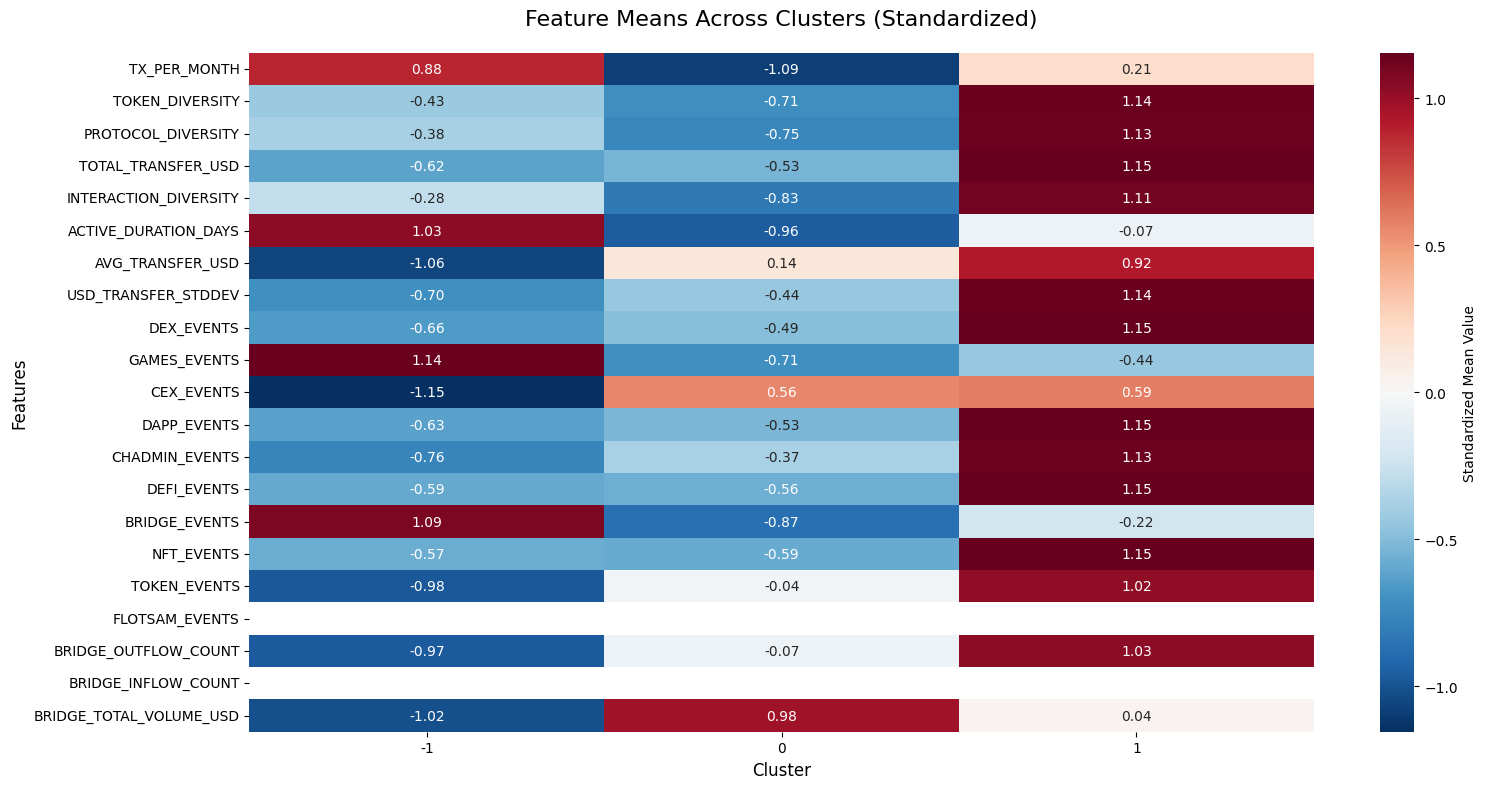

Actual Feature Means by Cluster:


TX_PER_MONTH  TOKEN_DIVERSITY  PROTOCOL_DIVERSITY  \
cluster                                                      
-1              73.37             3.04                5.77   
 0              10.08             2.50                2.83   
 1              52.02             6.03               17.84   

         TOTAL_TRANSFER_USD  INTERACTION_DIVERSITY  ACTIVE_DURATION_DAYS  \
cluster                                                                    
-1                   464.60                   6.78                140.31   
 0                106677.54                   3.16                 94.27   
 1               2233285.62                  16.07                114.96   

         AVG_TRANSFER_USD  USD_TRANSFER_STDDEV  DEX_EVENTS  GAMES_EVENTS  \
cluster                                                                    
-1                  17.38                15.86        0.61         16.97   
 0                1023.18              1746.26        2.98          2.59   
 1                1670.42             12092.13       26.75          4.66   

         CEX_EVENTS  DAPP_EVENTS  CHADMIN_EVENTS  DEFI_EVENTS  BRIDGE_EVENTS  \
cluster                                                                        
-1             0.14         0.01            0.00         0.39          57.34   
 0             0.29         0.37            1.48         0.57          10.67   
 1             0.30         6.50            7.14        10.67          26.21   

         NFT_EVENTS  TOKEN_EVENTS  FLOTSAM_EVENTS  BRIDGE_OUTFLOW_COUNT  \
cluster                                                                   
-1             0.54          0.41             0.0                  0.52   
 0             0.50          5.41             0.0                  8.83   
 1             4.45         11.11             0.0                 18.97   

         BRIDGE_INFLOW_COUNT  BRIDGE_TOTAL_VOLUME_USD  
cluster                                                
-1                       0.0                    27.56  
 0                       0.0                 33016.24  
 1                       0.0                 17395.98

In [24]:
# Create heatmap of feature means across clusters
feature_means_df = cluster_comparison.set_index('cluster')[[col for col in cluster_comparison.columns if col.endswith('_mean')]]
feature_means_df.columns = [col.replace('_mean', '') for col in feature_means_df.columns]

# Normalize features for better visualization (z-score normalization)
feature_means_normalized = (feature_means_df - feature_means_df.mean()) / feature_means_df.std()

plt.figure(figsize=(16, 8))
sns.heatmap(feature_means_normalized.T, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardized Mean Value'})
plt.title('Feature Means Across Clusters (Standardized)', fontsize=16, pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show the actual values
print("Actual Feature Means by Cluster:")
print("=" * 40)
display(feature_means_df.round(2))

Creating improved visualizations for better interpretability...
Features to analyze: ['TX_PER_MONTH', 'TOTAL_TRANSFER_USD', 'TOKEN_DIVERSITY', 'PROTOCOL_DIVERSITY', 'ACTIVE_DURATION_DAYS', 'AVG_TRANSFER_USD']


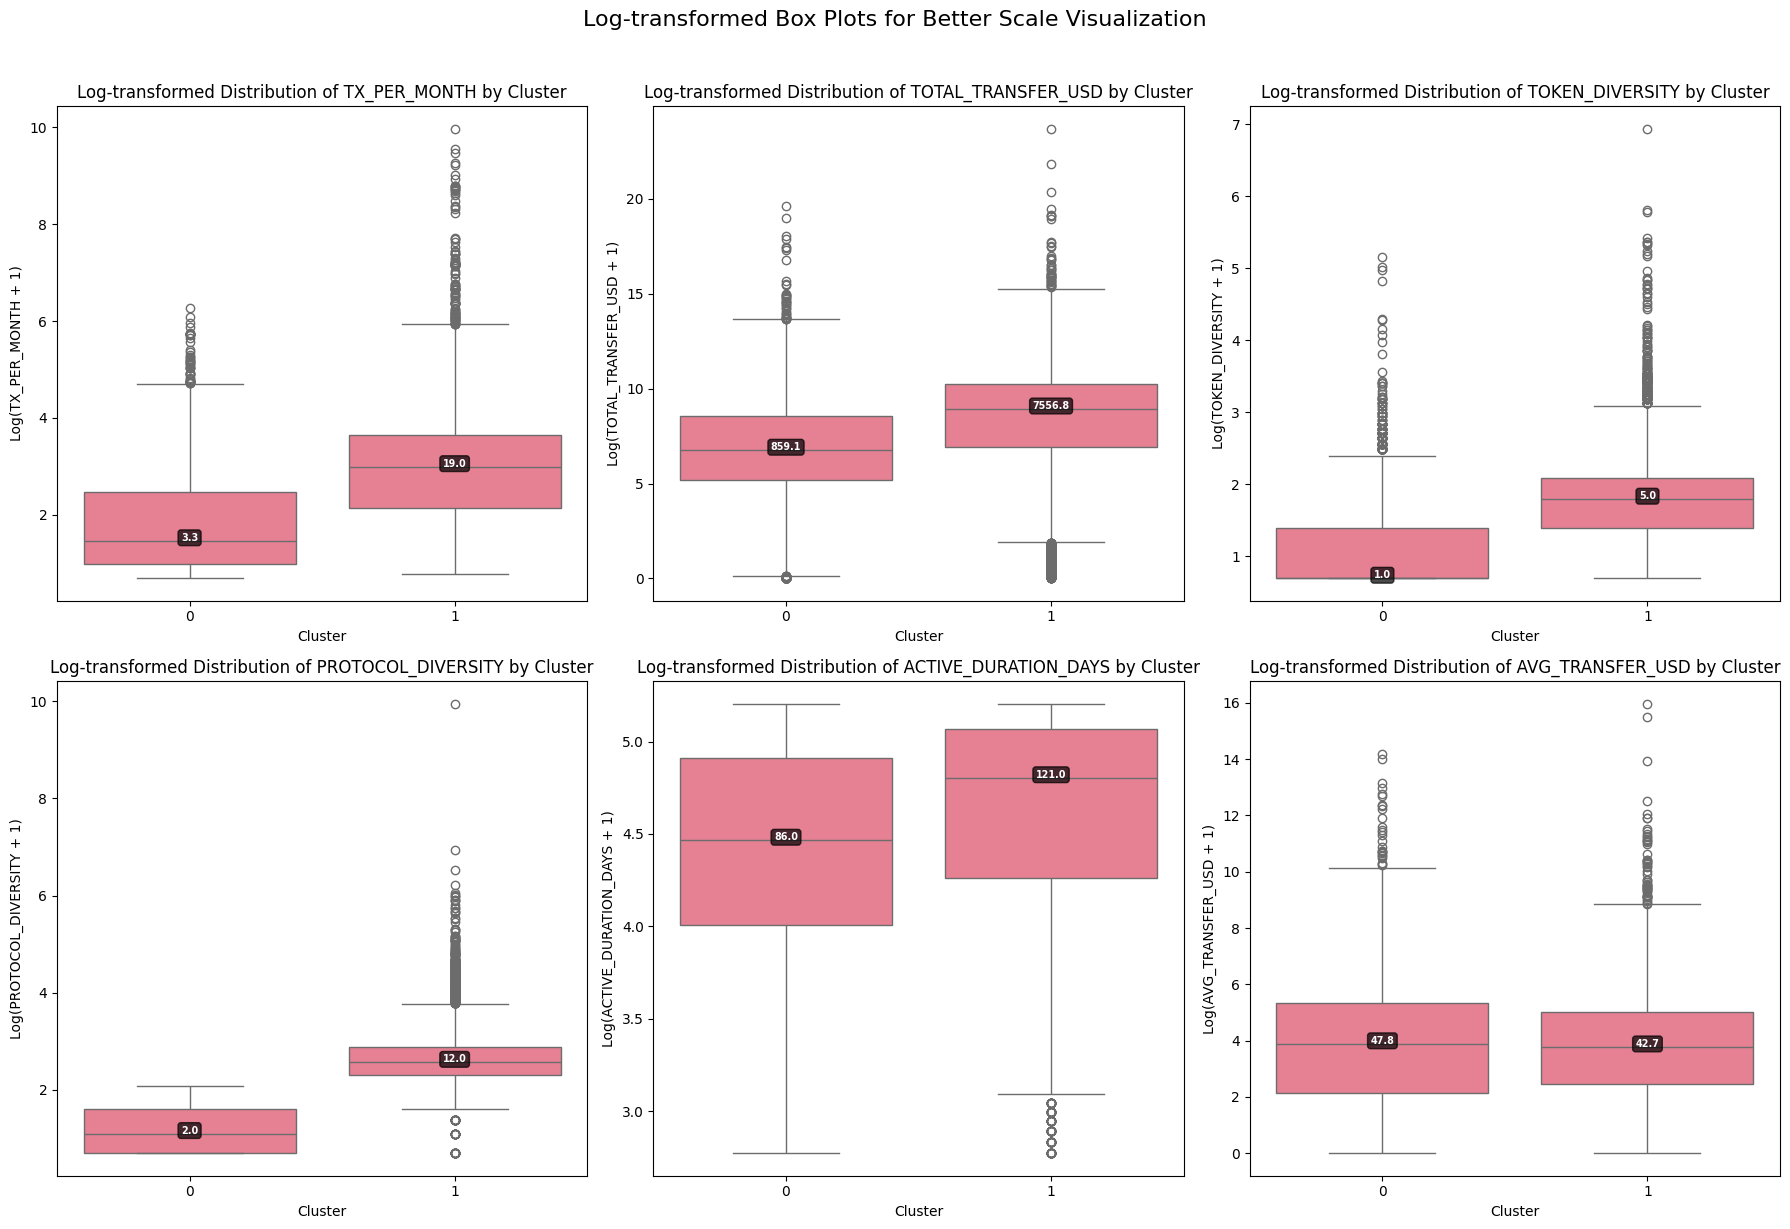

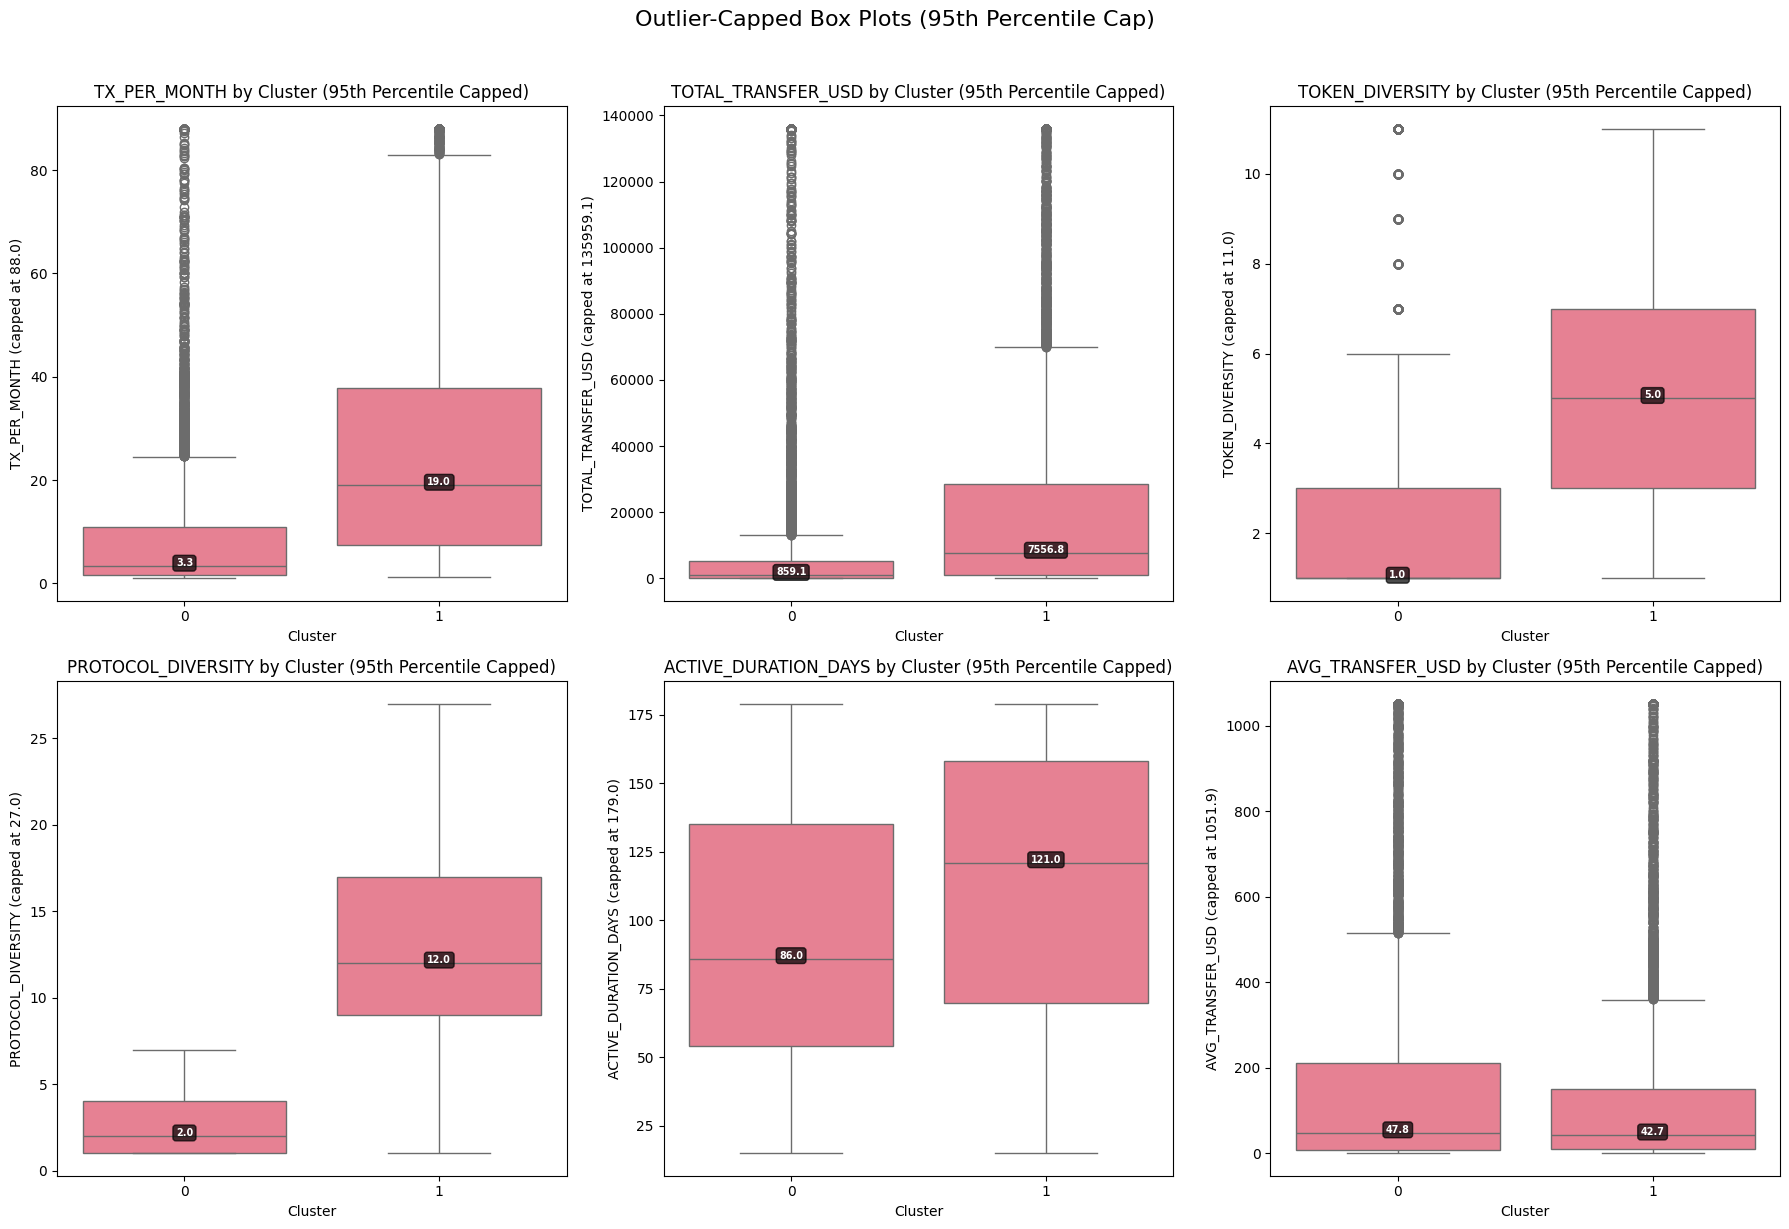


Creating interactive violin plots...



Summary Statistics by Cluster:

TX_PER_MONTH:


Count   Mean  Median     Std    Q1     Q3     P95       Max
cluster_label                                                             
0               8694  10.08    3.33   20.99  1.67  10.83   34.23    526.33
1              11383  52.02   19.00  387.48  7.50  37.75  117.17  21309.50


TOTAL_TRANSFER_USD:


Count        Mean  Median           Std       Q1        Q3  \
cluster_label                                                               
0               8694   106677.54   859.1  4.220986e+06   179.14   5348.93   
1              11383  2233285.62  7556.8  1.860534e+08  1005.79  28571.20   

                     P95           Max  
cluster_label                           
0               52175.90  3.338803e+08  
1              203953.64  1.960298e+10


TOKEN_DIVERSITY:


Count  Mean  Median    Std   Q1   Q3   P95   Max
cluster_label                                                  
0               8694  2.50     1.0   4.35  1.0  3.0   7.0   172
1              11383  6.03     5.0  13.21  3.0  7.0  13.0  1031


PROTOCOL_DIVERSITY:


Count   Mean  Median     Std   Q1    Q3   P95    Max
cluster_label                                                      
0               8694   2.83     2.0    1.70  1.0   4.0   6.0      7
1              11383  17.84    12.0  197.14  9.0  17.0  33.0  20923


ACTIVE_DURATION_DAYS:


Count    Mean  Median    Std    Q1     Q3    P95  Max
cluster_label                                                       
0               8694   94.27    86.0  49.23  54.0  135.0  178.0  181
1              11383  114.96   121.0  47.43  70.0  158.0  179.0  181


AVG_TRANSFER_USD:


Count     Mean  Median       Std     Q1      Q3      P95  \
cluster_label                                                             
0               8694  1023.18   47.78  22553.60   7.62  210.51  1499.01   
1              11383  1670.42   42.66  95066.85  10.87  150.88   693.19   

                      Max  
cluster_label              
0              1426838.77  
1              8572492.09

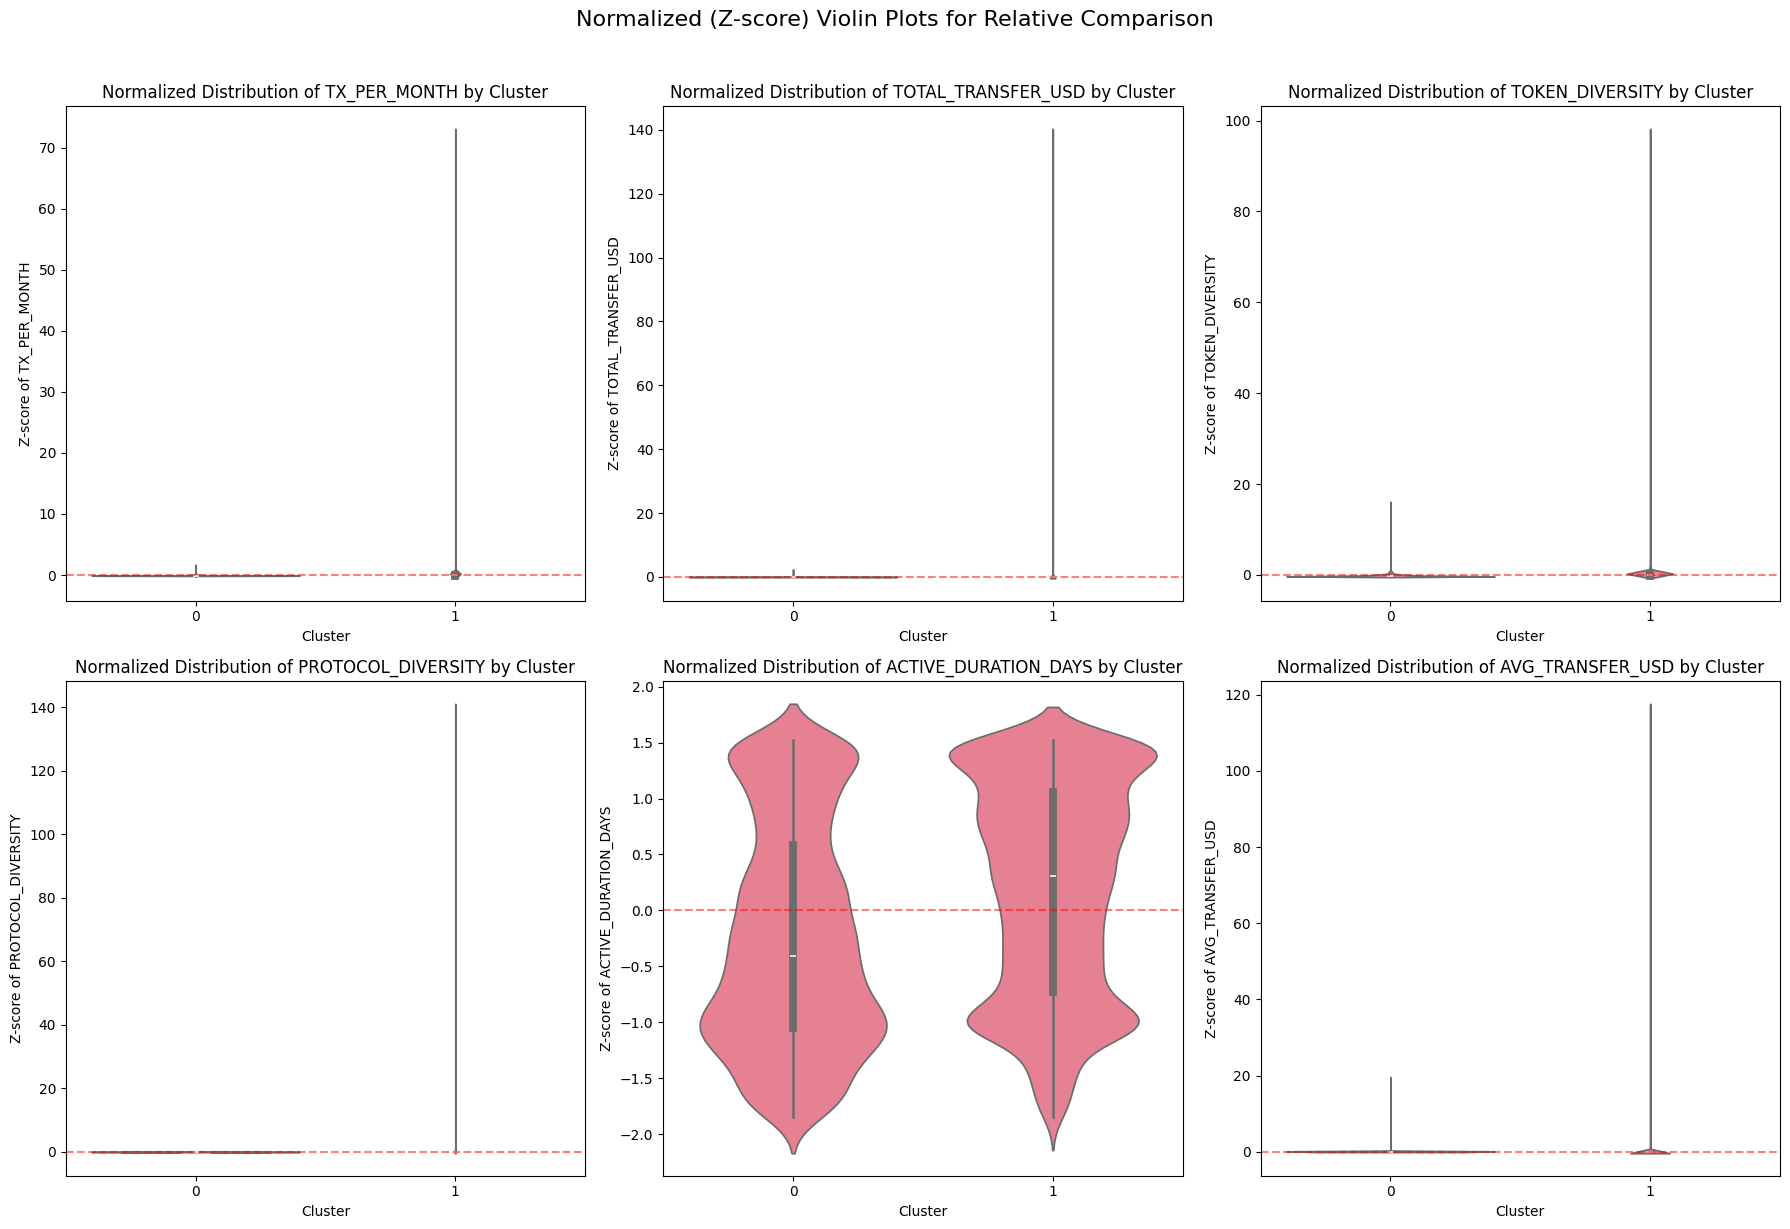


✅ Improved visualizations complete!
Key improvements:
• Log transformation reveals patterns in highly skewed data
• Outlier capping shows main distribution without extreme values
• Interactive plots allow detailed exploration
• Summary statistics provide precise numerical context
• Normalized plots enable relative comparison across features


In [25]:
# Create improved box plots for key features to show distributions
key_features = ['TX_PER_MONTH', 'TOTAL_TRANSFER_USD', 'TOKEN_DIVERSITY', 
                'PROTOCOL_DIVERSITY', 'ACTIVE_DURATION_DAYS', 'AVG_TRANSFER_USD']

# Filter to only include features that exist in our data
available_key_features = [feat for feat in key_features if feat in data_with_clusters.columns]

print("Creating improved visualizations for better interpretability...")
print(f"Features to analyze: {available_key_features}")

# Exclude noise for clarity
data_for_plot = data_with_clusters[data_with_clusters['cluster_label'] != -1].copy()

# Method 1: Log-transformed box plots for better scale visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(available_key_features):
    if i < len(axes):
        # Apply log transformation for better visualization (add 1 to handle zeros)
        log_feature = f'{feature}_log'
        data_for_plot[log_feature] = np.log1p(data_for_plot[feature])
        
        sns.boxplot(data=data_for_plot, x='cluster_label', y=log_feature, ax=axes[i])
        axes[i].set_title(f'Log-transformed Distribution of {feature} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(f'Log({feature} + 1)')
        axes[i].tick_params(axis='x', rotation=0)
        
        # Add median values as text
        medians = data_for_plot.groupby('cluster_label')[log_feature].median()
        for j, median in enumerate(medians):
            # Convert back to original scale for display
            original_median = np.expm1(median)
            axes[i].text(j, median, f'{original_median:.1f}', 
                        horizontalalignment='center', size='x-small', 
                        color='white', weight='semibold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))

# Hide unused subplots
for i in range(len(available_key_features), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Log-transformed Box Plots for Better Scale Visualization', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Method 2: Outlier-capped box plots (using 95th percentile caps)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(available_key_features):
    if i < len(axes):
        # Cap outliers at configured percentile for better visualization
        outlier_cap = data_for_plot[feature].quantile(CONFIG['OUTLIER_PERCENTILE'])
        capped_feature = f'{feature}_capped'
        data_for_plot[capped_feature] = np.minimum(data_for_plot[feature], outlier_cap)
        
        sns.boxplot(data=data_for_plot, x='cluster_label', y=capped_feature, ax=axes[i])
        axes[i].set_title(f'{feature} by Cluster ({CONFIG["OUTLIER_PERCENTILE"]*100:.0f}th Percentile Capped)')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(f'{feature} (capped at {outlier_cap:.1f})')
        axes[i].tick_params(axis='x', rotation=0)
        
        # Add median values as text
        medians = data_for_plot.groupby('cluster_label')[capped_feature].median()
        for j, median in enumerate(medians):
            axes[i].text(j, median, f'{median:.1f}', 
                        horizontalalignment='center', size='x-small', 
                        color='white', weight='semibold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))

# Hide unused subplots
for i in range(len(available_key_features), len(axes)):
    axes[i].set_visible(False)

plt.suptitle(f'Outlier-Capped Box Plots ({CONFIG["OUTLIER_PERCENTILE"]*100:.0f}th Percentile Cap)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Method 3: Interactive violin plots with hover information
print("\nCreating interactive violin plots...")

# Create subplots for interactive visualization
from plotly.subplots import make_subplots

n_features = len(available_key_features)
rows = 2
cols = 3

fig_interactive = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=[f'{feature}' for feature in available_key_features],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

for i, feature in enumerate(available_key_features):
    row = (i // cols) + 1
    col = (i % cols) + 1
    
    # Create violin plot for each cluster
    clusters = sorted(data_for_plot['cluster_label'].unique())
    for cluster in clusters:
        cluster_data = data_for_plot[data_for_plot['cluster_label'] == cluster][feature]
        
        fig_interactive.add_trace(
            go.Violin(
                y=cluster_data,
                name=f'Cluster {cluster}',
                box_visible=True,
                meanline_visible=True,
                showlegend=(i == 0),  # Only show legend for first subplot
                legendgroup=f'cluster_{cluster}',
                scalegroup=f'cluster_{cluster}',
                x=[f'Cluster {cluster}'] * len(cluster_data)
            ),
            row=row, col=col
        )

fig_interactive.update_layout(
    title_text="Interactive Distribution Analysis by Cluster",
    title_x=0.5,
    height=800,
    showlegend=True
)

# Update y-axes to use log scale for better visibility
for i in range(1, rows * cols + 1):
    fig_interactive.update_yaxes(type="log", row=(i-1)//cols + 1, col=(i-1)%cols + 1)

fig_interactive.show()

# Method 4: Side-by-side comparison with summary statistics
print("\nSummary Statistics by Cluster:")
print("=" * 50)

for feature in available_key_features:
    print(f"\n{feature}:")
    summary_stats = data_for_plot.groupby('cluster_label')[feature].agg([
        'count', 'mean', 'median', 'std', 
        lambda x: x.quantile(0.25),  # Q1
        lambda x: x.quantile(0.75),  # Q3
        lambda x: x.quantile(CONFIG['OUTLIER_PERCENTILE']),  # Configured percentile
        'max'
    ]).round(2)
    summary_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Q1', 'Q3', f'P{CONFIG["OUTLIER_PERCENTILE"]*100:.0f}', 'Max']
    display(summary_stats)

# Method 5: Normalized violin plots for relative comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(available_key_features):
    if i < len(axes):
        # Create normalized data (z-score within each cluster)
        data_normalized = data_for_plot.copy()
        feature_mean = data_for_plot[feature].mean()
        feature_std = data_for_plot[feature].std()
        data_normalized[f'{feature}_zscore'] = (data_for_plot[feature] - feature_mean) / feature_std
        
        sns.violinplot(data=data_normalized, x='cluster_label', y=f'{feature}_zscore', ax=axes[i])
        axes[i].set_title(f'Normalized Distribution of {feature} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(f'Z-score of {feature}')
        axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[i].tick_params(axis='x', rotation=0)

# Hide unused subplots
for i in range(len(available_key_features), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Normalized (Z-score) Violin Plots for Relative Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ Improved visualizations complete!")
print("Key improvements:")
print("• Log transformation reveals patterns in highly skewed data")
print("• Outlier capping shows main distribution without extreme values")
print("• Interactive plots allow detailed exploration")
print("• Summary statistics provide precise numerical context")
print("• Normalized plots enable relative comparison across features")

## 3. Cluster Behavior Analysis

Let's analyze the behavioral patterns and event types across clusters to understand what makes each cluster unique.

Event type columns found: ['DEX_EVENTS', 'GAMES_EVENTS', 'CEX_EVENTS', 'DAPP_EVENTS', 'CHADMIN_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS', 'NFT_EVENTS', 'TOKEN_EVENTS', 'FLOTSAM_EVENTS']
Bridge-related columns found: ['BRIDGE_EVENTS', 'BRIDGE_OUTFLOW_COUNT', 'BRIDGE_INFLOW_COUNT', 'BRIDGE_TOTAL_VOLUME_USD']


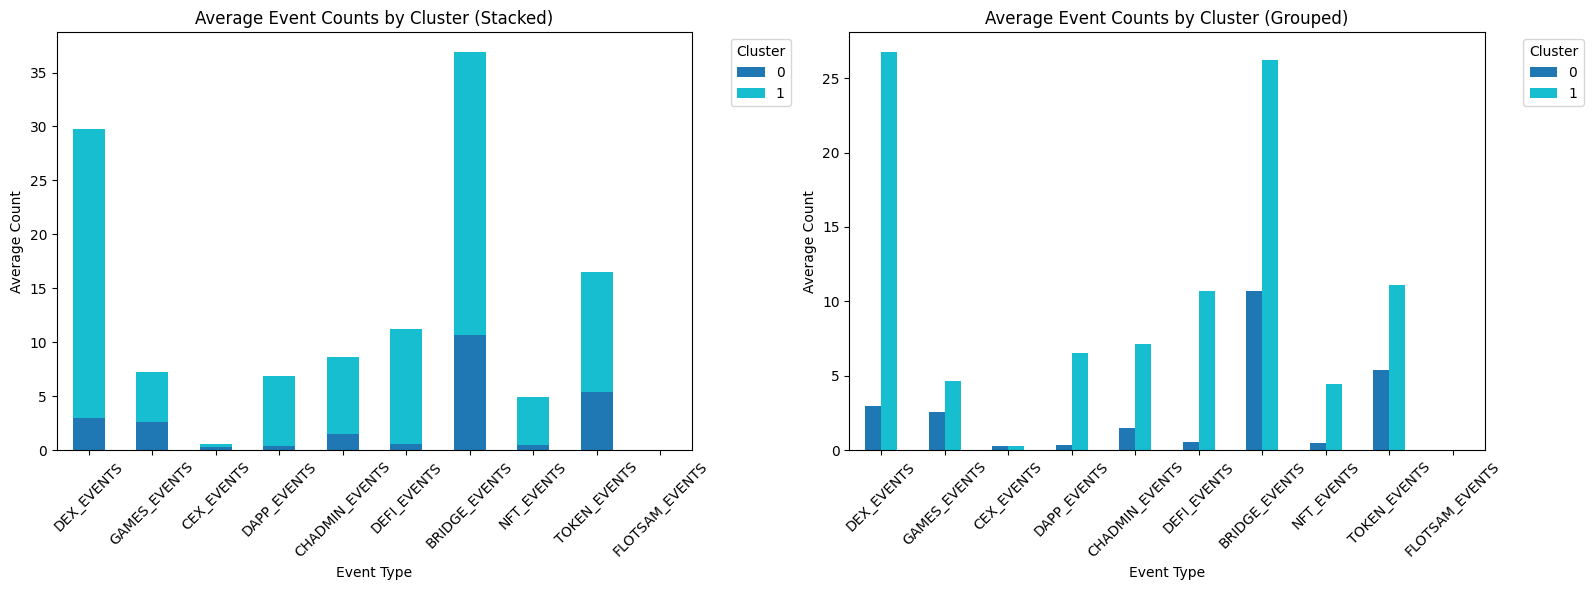

Event Analysis Summary:


DEX_EVENTS  GAMES_EVENTS  CEX_EVENTS  DAPP_EVENTS  \
cluster_label                                                      
0                    2.98          2.59        0.29         0.37   
1                   26.75          4.66        0.30         6.50   

               CHADMIN_EVENTS  DEFI_EVENTS  BRIDGE_EVENTS  NFT_EVENTS  \
cluster_label                                                           
0                        1.48         0.57          10.67        0.50   
1                        7.14        10.67          26.21        4.45   

               TOKEN_EVENTS  FLOTSAM_EVENTS  
cluster_label                                
0                      5.41             0.0  
1                     11.11             0.0

<Figure size 1200x600 with 0 Axes>

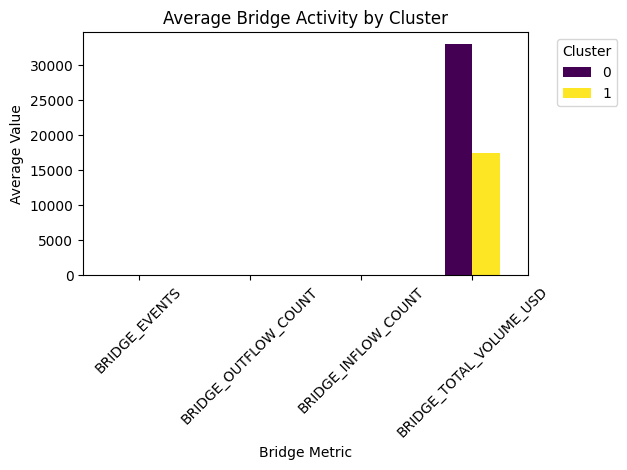

Bridge Activity Analysis:


BRIDGE_EVENTS  BRIDGE_OUTFLOW_COUNT  BRIDGE_INFLOW_COUNT  \
cluster_label                                                             
0                      10.67                  8.83                  0.0   
1                      26.21                 18.97                  0.0   

               BRIDGE_TOTAL_VOLUME_USD  
cluster_label                           
0                             33016.24  
1                             17395.98

In [26]:
# Analyze event types across clusters
event_columns = [col for col in data_with_clusters.columns if col.endswith('_EVENTS')]
bridge_columns = [col for col in data_with_clusters.columns if 'BRIDGE' in col]

print("Event type columns found:", event_columns)
print("Bridge-related columns found:", bridge_columns)

# Create event analysis for clusters (excluding noise)
clustered_data_only = data_with_clusters[data_with_clusters['cluster_label'] != -1].copy()

if event_columns:
    # Calculate mean event counts by cluster
    event_analysis = clustered_data_only.groupby('cluster_label')[event_columns].mean()
    
    # Create stacked bar chart for event types
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Stacked bar chart
    event_analysis.T.plot(kind='bar', stacked=True, ax=ax1, colormap='tab10')
    ax1.set_title('Average Event Counts by Cluster (Stacked)')
    ax1.set_xlabel('Event Type')
    ax1.set_ylabel('Average Count')
    ax1.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # Grouped bar chart
    event_analysis.T.plot(kind='bar', ax=ax2, colormap='tab10')
    ax2.set_title('Average Event Counts by Cluster (Grouped)')
    ax2.set_xlabel('Event Type')
    ax2.set_ylabel('Average Count')
    ax2.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("Event Analysis Summary:")
    print("=" * 30)
    display(event_analysis.round(2))

# Analyze bridge activity if available
if bridge_columns:
    bridge_analysis = clustered_data_only.groupby('cluster_label')[bridge_columns].mean()
    
    plt.figure(figsize=(12, 6))
    bridge_analysis.T.plot(kind='bar', colormap='viridis')
    plt.title('Average Bridge Activity by Cluster')
    plt.xlabel('Bridge Metric')
    plt.ylabel('Average Value')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Bridge Activity Analysis:")
    print("=" * 30)
    display(bridge_analysis.round(2))

## 4. Statistical Significance Analysis

Let's test whether the differences between clusters are statistically significant.

In [27]:
# Statistical significance testing between clusters
from scipy import stats
from itertools import combinations

def perform_cluster_significance_tests(data, features, cluster_col='cluster_label'):
    """Perform statistical tests between clusters for each feature"""
    
    clustered_data_only = data[data[cluster_col] != -1].copy()
    clusters = sorted(clustered_data_only[cluster_col].unique())
    
    results = {}
    
    for feature in features:
        if feature not in clustered_data_only.columns:
            continue
            
        feature_results = {}
        
        # ANOVA test for overall significance
        cluster_groups = [clustered_data_only[clustered_data_only[cluster_col] == c][feature].values 
                         for c in clusters]
        
        # Remove any empty groups
        cluster_groups = [group for group in cluster_groups if len(group) > 0]
        
        if len(cluster_groups) >= 2:
            f_stat, p_value = stats.f_oneway(*cluster_groups)
            feature_results['anova'] = {
                'f_statistic': f_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            }
            
            # Pairwise t-tests between clusters
            pairwise_results = {}
            for cluster1, cluster2 in combinations(clusters, 2):
                group1 = clustered_data_only[clustered_data_only[cluster_col] == cluster1][feature].values
                group2 = clustered_data_only[clustered_data_only[cluster_col] == cluster2][feature].values
                
                if len(group1) > 0 and len(group2) > 0:
                    t_stat, p_val = stats.ttest_ind(group1, group2)
                    pairwise_results[f'{cluster1}_vs_{cluster2}'] = {
                        't_statistic': t_stat,
                        'p_value': p_val,
                        'significant': p_val < 0.05
                    }
            
            feature_results['pairwise'] = pairwise_results
        
        results[feature] = feature_results
    
    return results

# Perform significance tests
significance_results = perform_cluster_significance_tests(
    data_with_clusters, 
    available_key_features
)

# Display results
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("=" * 50)

for feature, results in significance_results.items():
    if 'anova' in results:
        anova = results['anova']
        significance = "✓ SIGNIFICANT" if anova['significant'] else "✗ Not significant"
        
        print(f"\n{feature}:")
        print(f"  ANOVA F-test: F={anova['f_statistic']:.2f}, p={anova['p_value']:.4f} {significance}")
        
        # Show significant pairwise comparisons
        if 'pairwise' in results:
            significant_pairs = [(pair, data) for pair, data in results['pairwise'].items() 
                               if data['significant']]
            
            if significant_pairs:
                print(f"  Significant pairwise differences:")
                for pair, data in significant_pairs:
                    print(f"    {pair}: t={data['t_statistic']:.2f}, p={data['p_value']:.4f}")

# Create summary table of significant features
significant_features = []
for feature, results in significance_results.items():
    if 'anova' in results and results['anova']['significant']:
        significant_features.append({
            'Feature': feature,
            'F-statistic': f"{results['anova']['f_statistic']:.2f}",
            'p-value': f"{results['anova']['p_value']:.4f}",
            'Significant_Pairs': len([p for p in results.get('pairwise', {}).values() if p['significant']])
        })

if significant_features:
    sig_df = pd.DataFrame(significant_features)
    print(f"\nSignificant Features Summary:")
    print("=" * 30)
    display(sig_df)
else:
    print("\nNo features showed statistically significant differences between clusters.")

STATISTICAL SIGNIFICANCE ANALYSIS

TX_PER_MONTH:
  ANOVA F-test: F=101.66, p=0.0000 ✓ SIGNIFICANT
  Significant pairwise differences:
    0_vs_1: t=-10.08, p=0.0000

TOTAL_TRANSFER_USD:
  ANOVA F-test: F=1.14, p=0.2866 ✗ Not significant

TOKEN_DIVERSITY:
  ANOVA F-test: F=571.85, p=0.0000 ✓ SIGNIFICANT
  Significant pairwise differences:
    0_vs_1: t=-23.91, p=0.0000

PROTOCOL_DIVERSITY:
  ANOVA F-test: F=50.35, p=0.0000 ✓ SIGNIFICANT
  Significant pairwise differences:
    0_vs_1: t=-7.10, p=0.0000

ACTIVE_DURATION_DAYS:
  ANOVA F-test: F=906.94, p=0.0000 ✓ SIGNIFICANT
  Significant pairwise differences:
    0_vs_1: t=-30.12, p=0.0000

AVG_TRANSFER_USD:
  ANOVA F-test: F=0.39, p=0.5342 ✗ Not significant

Significant Features Summary:


Feature F-statistic p-value  Significant_Pairs
0          TX_PER_MONTH      101.66  0.0000                  1
1       TOKEN_DIVERSITY      571.85  0.0000                  1
2    PROTOCOL_DIVERSITY       50.35  0.0000                  1
3  ACTIVE_DURATION_DAYS      906.94  0.0000                  1

## 5. Business Insights and Recommendations

Based on the clustering analysis, let's derive actionable business insights and recommendations.

In [28]:
# Create cluster personas based on distinguishing characteristics
def create_cluster_personas(cluster_stats, feature_means_df, features):
    """Generate descriptive personas for each cluster based on their characteristics"""
    
    personas = {}
    
    # Define thresholds for characteristics (can be adjusted based on domain knowledge)
    PERSONA_THRESHOLDS = {
        'TOTAL_TRANSFER_USD': {'high': CONFIG['HIGH_VOLUME_THRESHOLD'], 'medium': CONFIG['MEDIUM_VOLUME_THRESHOLD']},
        'TX_PER_MONTH': {'high': CONFIG['HIGH_ACTIVITY_THRESHOLD'], 'medium': CONFIG['LOW_ACTIVITY_THRESHOLD']},
        'TOKEN_DIVERSITY': {'high': CONFIG['HIGH_TOKEN_DIVERSITY_THRESHOLD'], 'medium': 3},
        'PROTOCOL_DIVERSITY': {'high': CONFIG['HIGH_PROTOCOL_DIVERSITY_THRESHOLD'], 'medium': 5},
        'ACTIVE_DURATION_DAYS': {'high': CONFIG['LONG_TERM_USER_THRESHOLD'], 'medium': 30},
        'AVG_TRANSFER_USD': {'high': CONFIG['LARGE_TX_THRESHOLD'], 'medium': CONFIG['MEDIUM_TX_THRESHOLD']}
    }
    
    for cluster_id, stats in cluster_stats.items():
        if cluster_id == -1:  # Skip noise points
            continue
            
        characteristics = []
        
        # Get cluster data from feature means
        if cluster_id in feature_means_df.index:
            cluster_data = feature_means_df.loc[cluster_id]
            
            # Analyze volume characteristics
            total_volume = cluster_data.get('TOTAL_TRANSFER_USD', 0)
            if total_volume >= PERSONA_THRESHOLDS['TOTAL_TRANSFER_USD']['high']:
                characteristics.append("High-Volume Traders")
            elif total_volume >= PERSONA_THRESHOLDS['TOTAL_TRANSFER_USD']['medium']:
                characteristics.append("Medium-Volume Users")
            else:
                characteristics.append("Low-Volume Users")
            
            # Analyze activity characteristics
            tx_frequency = cluster_data.get('TX_PER_MONTH', 0)
            if tx_frequency >= PERSONA_THRESHOLDS['TX_PER_MONTH']['high']:
                characteristics.append("Very Active")
            elif tx_frequency >= PERSONA_THRESHOLDS['TX_PER_MONTH']['medium']:
                characteristics.append("Moderately Active")
            else:
                characteristics.append("Low Activity")
            
            # Analyze diversification
            token_div = cluster_data.get('TOKEN_DIVERSITY', 0)
            if token_div >= PERSONA_THRESHOLDS['TOKEN_DIVERSITY']['high']:
                characteristics.append("Highly Diversified Portfolio")
            elif token_div >= PERSONA_THRESHOLDS['TOKEN_DIVERSITY']['medium']:
                characteristics.append("Moderately Diversified")
            else:
                characteristics.append("Focused Portfolio")
            
            protocol_div = cluster_data.get('PROTOCOL_DIVERSITY', 0)
            if protocol_div >= PERSONA_THRESHOLDS['PROTOCOL_DIVERSITY']['high']:
                characteristics.append("Multi-Protocol Power Users")
            elif protocol_div >= PERSONA_THRESHOLDS['PROTOCOL_DIVERSITY']['medium']:
                characteristics.append("Cross-Protocol Users")
            else:
                characteristics.append("Single-Protocol Users")
            
            # Analyze transaction size patterns
            avg_tx = cluster_data.get('AVG_TRANSFER_USD', 0)
            if avg_tx >= PERSONA_THRESHOLDS['AVG_TRANSFER_USD']['high']:
                characteristics.append("Large Transaction Preference")
            elif avg_tx >= PERSONA_THRESHOLDS['AVG_TRANSFER_USD']['medium']:
                characteristics.append("Medium Transaction Size")
            else:
                characteristics.append("Small Transaction Preference")
            
            # Analyze duration/loyalty
            duration = cluster_data.get('ACTIVE_DURATION_DAYS', 0)
            if duration >= PERSONA_THRESHOLDS['ACTIVE_DURATION_DAYS']['high']:
                characteristics.append("Long-term Users")
            elif duration >= PERSONA_THRESHOLDS['ACTIVE_DURATION_DAYS']['medium']:
                characteristics.append("Medium-term Users")
            else:
                characteristics.append("New/Short-term Users")
        
        # If no characteristics derived from features, use basic description
        if not characteristics:
            characteristics = ["Standard Users"]
        
        personas[cluster_id] = {
            'size': stats['size'],
            'percentage': stats['percentage'],
            'characteristics': characteristics
        }
    
    return personas

# Generate cluster personas
personas = create_cluster_personas(cluster_stats, feature_means_df, features)

print("CLUSTER PERSONAS GENERATED")
print("=" * 40)

for cluster_id, persona in personas.items():
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {persona['size']:,} wallets ({persona['percentage']:.1f}%)")
    print(f"  Characteristics: {' | '.join(persona['characteristics'])}")

print(f"\n✅ Generated personas for {len(personas)} clusters")
print(f"Ready to use in business insights generation!")

CLUSTER PERSONAS GENERATED

Cluster 0:
  Size: 8,694 wallets (43.1%)
  Characteristics: High-Volume Traders | Moderately Active | Focused Portfolio | Single-Protocol Users | Large Transaction Preference | Medium-term Users

Cluster 1:
  Size: 11,383 wallets (56.4%)
  Characteristics: High-Volume Traders | Very Active | Highly Diversified Portfolio | Multi-Protocol Power Users | Large Transaction Preference | Medium-term Users

✅ Generated personas for 2 clusters
Ready to use in business insights generation!


In [29]:
# Generate business insights and recommendations
def generate_business_insights(personas, feature_means_df, cluster_stats):
    """Generate actionable business insights from cluster analysis"""
    
    insights = {
        'cluster_insights': {},
        'overall_insights': [],
        'recommendations': []
    }
    
    total_wallets = sum(stats['size'] for stats in cluster_stats.values() if stats is not None)
    
    for cluster_id, persona in personas.items():
        cluster_data = feature_means_df.loc[cluster_id]
        
        # Cluster-specific insights
        cluster_insights = []
        
        # Volume insights
        total_volume = cluster_data.get('TOTAL_TRANSFER_USD', 0)
        if total_volume > CONFIG['LOW_VALUE_SEGMENT_THRESHOLD']:
            cluster_insights.append(f"High value segment with average ${total_volume:,.0f} per wallet")
        
        # Activity insights
        tx_frequency = cluster_data.get('TX_PER_MONTH', 0)
        if tx_frequency > CONFIG['HIGH_ACTIVITY_THRESHOLD']:
            cluster_insights.append(f"Very active users with {tx_frequency:.1f} transactions/month")
        elif tx_frequency < CONFIG['LOW_ACTIVITY_THRESHOLD']:
            cluster_insights.append(f"Low activity users with only {tx_frequency:.1f} transactions/month")
        
        # Diversification insights
        token_div = cluster_data.get('TOKEN_DIVERSITY', 0)
        protocol_div = cluster_data.get('PROTOCOL_DIVERSITY', 0)
        if token_div > CONFIG['HIGH_TOKEN_DIVERSITY_THRESHOLD']:
            cluster_insights.append(f"Highly diversified token portfolio ({token_div:.1f} tokens)")
        if protocol_div > CONFIG['HIGH_PROTOCOL_DIVERSITY_THRESHOLD']:
            cluster_insights.append(f"Multi-protocol users ({protocol_div:.1f} protocols)")
        
        insights['cluster_insights'][cluster_id] = {
            'size': persona['size'],
            'percentage': persona['percentage'],
            'profile': persona['characteristics'],
            'insights': cluster_insights
        }
    
    # Overall insights
    largest_cluster = max(personas.keys(), key=lambda x: personas[x]['size'])
    smallest_cluster = min(personas.keys(), key=lambda x: personas[x]['size'])
    
    insights['overall_insights'].extend([
        f"Identified {len(personas)} distinct user segments from {total_wallets:,} wallets",
        f"Largest segment: Cluster {largest_cluster} with {personas[largest_cluster]['size']:,} wallets ({personas[largest_cluster]['percentage']:.1f}%)",
        f"Smallest segment: Cluster {smallest_cluster} with {personas[smallest_cluster]['size']:,} wallets ({personas[smallest_cluster]['percentage']:.1f}%)",
        f"Noise points: {cluster_stats.get(-1, {}).get('size', 0):,} wallets represent outliers or unique behaviors"
    ])
    
    # Generate recommendations
    recommendations = []
    
    for cluster_id, cluster_insight in insights['cluster_insights'].items():
        if cluster_insight['percentage'] > 50:  # Major segment
            recommendations.append(f"Cluster {cluster_id}: Focus primary product features on this major segment")
        elif cluster_insight['percentage'] > 20:  # Significant segment
            recommendations.append(f"Cluster {cluster_id}: Develop targeted features for this significant segment")
        else:  # Niche segment
            recommendations.append(f"Cluster {cluster_id}: Consider specialized offerings for this niche segment")
        
        # Volume-based recommendations
        cluster_data = feature_means_df.loc[cluster_id]
        if cluster_data.get('TOTAL_TRANSFER_USD', 0) > CONFIG['HIGH_VOLUME_THRESHOLD']:
            recommendations.append(f"Cluster {cluster_id}: High-value users - prioritize premium features and support")
        elif cluster_data.get('TOTAL_TRANSFER_USD', 0) < CONFIG['MEDIUM_VOLUME_THRESHOLD']:
            recommendations.append(f"Cluster {cluster_id}: Low-value users - focus on engagement and education")
    
    insights['recommendations'] = recommendations
    
    return insights

# Generate insights
business_insights = generate_business_insights(personas, feature_means_df, cluster_stats)

print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("=" * 60)

print("\n📊 OVERALL INSIGHTS:")
for insight in business_insights['overall_insights']:
    print(f"• {insight}")

print(f"\n🎯 CLUSTER-SPECIFIC INSIGHTS:")
for cluster_id, cluster_info in business_insights['cluster_insights'].items():
    print(f"\nCluster {cluster_id} ({cluster_info['size']:,} wallets, {cluster_info['percentage']:.1f}%):")
    print(f"  Profile: {' | '.join(cluster_info['profile'][:3])}")
    for insight in cluster_info['insights']:
        print(f"  • {insight}")

print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
for i, recommendation in enumerate(business_insights['recommendations'], 1):
    print(f"{i}. {recommendation}")

# Create action priority matrix
action_matrix = []
for cluster_id, cluster_info in business_insights['cluster_insights'].items():
    cluster_data = feature_means_df.loc[cluster_id]
    
    # Calculate priority score (size * value)
    priority_score = cluster_info['percentage'] * cluster_data.get('TOTAL_TRANSFER_USD', 0) / CONFIG['PRIORITY_DIVIDER']
    
    action_matrix.append({
        'Cluster': cluster_id,
        'Size (%)': f"{cluster_info['percentage']:.1f}%",
        'Avg Value ($)': f"{cluster_data.get('TOTAL_TRANSFER_USD', 0):,.0f}",
        'Priority Score': f"{priority_score:.1f}",
        'Action Priority': 'High' if priority_score > CONFIG['HIGH_PRIORITY_THRESHOLD'] else 'Medium' if priority_score > CONFIG['MEDIUM_PRIORITY_THRESHOLD'] else 'Low'
    })

action_df = pd.DataFrame(action_matrix).sort_values('Priority Score', ascending=False)
print(f"\n📋 ACTION PRIORITY MATRIX:")
print("=" * 30)
display(action_df)

BUSINESS INSIGHTS & RECOMMENDATIONS

📊 OVERALL INSIGHTS:
• Identified 2 distinct user segments from 20,174 wallets
• Largest segment: Cluster 1 with 11,383 wallets (56.4%)
• Smallest segment: Cluster 0 with 8,694 wallets (43.1%)
• Noise points: 97 wallets represent outliers or unique behaviors

🎯 CLUSTER-SPECIFIC INSIGHTS:

Cluster 0 (8,694 wallets, 43.1%):
  Profile: High-Volume Traders | Moderately Active | Focused Portfolio
  • High value segment with average $106,678 per wallet

Cluster 1 (11,383 wallets, 56.4%):
  Profile: High-Volume Traders | Very Active | Highly Diversified Portfolio
  • High value segment with average $2,233,286 per wallet
  • Very active users with 52.0 transactions/month
  • Highly diversified token portfolio (6.0 tokens)
  • Multi-protocol users (17.8 protocols)

💡 STRATEGIC RECOMMENDATIONS:
1. Cluster 0: Develop targeted features for this significant segment
2. Cluster 0: High-value users - prioritize premium features and support
3. Cluster 1: Focus primar

Cluster Size (%) Avg Value ($) Priority Score Action Priority
0        0    43.1%       106,678         4597.3            High
1        1    56.4%     2,233,286       126011.2            High

## 6. Summary and Export

Final summary of the clustering evaluation and data export for further analysis.

In [30]:
# Create comprehensive summary report
summary_report = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_info': {
        'total_wallets': len(data_with_clusters),
        'total_features': len(features),
        'data_source': 'new_raw_data_polygon.csv'
    },
    'clustering_results': {
        'algorithm': 'HDBSCAN',
        'num_clusters': len([c for c in data_with_clusters['cluster_label'].unique() if c != -1]),
        'noise_points': len(data_with_clusters[data_with_clusters['cluster_label'] == -1]),
        'noise_percentage': (len(data_with_clusters[data_with_clusters['cluster_label'] == -1]) / len(data_with_clusters)) * 100,
        'silhouette_score': metrics.get('Silhouette Score', 0.0),  # 0.0 if calculation failed
        'calinski_harabasz_score': metrics.get('Calinski-Harabasz Score', 0.0),  # 0.0 if calculation failed
        'davies_bouldin_score': metrics.get('Davies-Bouldin Score', 1.0)  # 1.0 (worst score) if calculation failed
    },
    'cluster_profiles': {},
    'significant_features': [f for f, r in significance_results.items() 
                           if 'anova' in r and r['anova']['significant']],
    'business_insights': business_insights
}

# Add cluster profiles to summary
for cluster_id, persona in personas.items():
    cluster_data = feature_means_df.loc[cluster_id]
    summary_report['cluster_profiles'][f'cluster_{cluster_id}'] = {
        'size': persona['size'],
        'percentage': persona['percentage'],
        'characteristics': persona['characteristics'],
        'key_metrics': {
            'avg_total_transfer_usd': cluster_data.get('TOTAL_TRANSFER_USD', 0),
            'avg_tx_per_month': cluster_data.get('TX_PER_MONTH', 0),
            'avg_token_diversity': cluster_data.get('TOKEN_DIVERSITY', 0),
            'avg_protocol_diversity': cluster_data.get('PROTOCOL_DIVERSITY', 0)
        }
    }

print("CLUSTERING EVALUATION SUMMARY")
print("=" * 50)
print(f"Analysis completed: {summary_report['analysis_date']}")
print(f"Dataset: {summary_report['dataset_info']['total_wallets']:,} wallets with {summary_report['dataset_info']['total_features']} features")
print(f"Clusters identified: {summary_report['clustering_results']['num_clusters']}")
print(f"Noise points: {summary_report['clustering_results']['noise_points']:,} ({summary_report['clustering_results']['noise_percentage']:.1f}%)")
print(f"Silhouette Score: {summary_report['clustering_results']['silhouette_score']:.3f}")

print(f"\nKey Findings:")
print(f"• {len(summary_report['significant_features'])} features showed statistically significant differences between clusters")
print(f"• Largest cluster contains {max(p['size'] for p in personas.values()):,} wallets")
print(f"• {len(business_insights['recommendations'])} strategic recommendations generated")

# Export results for further analysis
export_data = data_with_clusters.copy()
export_data['cluster_persona'] = export_data['cluster_label'].map(
    {cluster_id: ' | '.join(persona['characteristics'][:2]) 
     for cluster_id, persona in personas.items()}
)

# Save to CSV
output_path = base_path / 'clustering_output/hdbscan_evaluation_results.csv'
export_data.to_csv(output_path, index=False)
print(f"\n💾 Results exported to: {output_path}")

# Save summary report
import json
summary_path = base_path / 'clustering_output/hdbscan_evaluation_summary.json'
with open(summary_path, 'w') as f:
    # Convert numpy types to Python types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    
    def recursive_convert(data):
        if isinstance(data, dict):
            return {k: recursive_convert(v) for k, v in data.items()}
        elif isinstance(data, list):
            return [recursive_convert(item) for item in data]
        else:
            return convert_numpy(data)
    
    json.dump(recursive_convert(summary_report), f, indent=2)

print(f"📊 Summary report saved to: {summary_path}")

print(f"\n✅ CLUSTERING EVALUATION COMPLETE")
print(f"This analysis provides comprehensive insights into wallet behavior patterns")
print(f"and can be used to inform product strategy and user experience decisions.")

CLUSTERING EVALUATION SUMMARY
Analysis completed: 2025-07-25 11:22:59
Dataset: 20,174 wallets with 21 features
Clusters identified: 2
Noise points: 97 (0.5%)
Silhouette Score: 0.458

Key Findings:
• 4 features showed statistically significant differences between clusters
• Largest cluster contains 11,383 wallets
• 4 strategic recommendations generated

💾 Results exported to: /Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/hdbscan_evaluation_results.csv

💾 Results exported to: /Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/hdbscan_evaluation_results.csv


TypeError: keys must be str, int, float, bool or None, not int64